# Repository Discovery

# Table of Contents
- [Introduction](#introduction)
- [Initial Setup](#setup)
- [Known Contributors](#known-contributors)
- [Event Analysis](#contribution-event-stream-analysis)
- [Known Contributor Event Analysis](#known-contributors-event-stream-analysis)
- [Implement Alpha and Beta Indices](#implement-alpha-and-beta-indices-of-preference)
  - [Alpha Index](#implement-alpha)
  - [Beta Index](#implement-beta)
- [Conclusion](#conclusion)

## Introduction

It is difficult, without specialized knowledge or dedicated inspection, to determine how repos on Github are related to one another.

Which projects (repos) are trying to solve the same problem? Which are in the same ecosystem? Which pre-date which others?

We've begun to study this problem using the abstract model of networks. Our approach is summarized by the neuroscience Hebbian mneumonic approximation: "fire together, wire together."
Said with greater context, groups of projects that share features (contributors, in this first exploration) are more likely than others to do similar things.

We expect projects in the container orchestration space to, pairwise, share more contributors together than with projects outside of that context, on average.

## This notebook's contribution

In this notebook, we attempt to solve a challenging problem:

Given the contributors in a known kernel of projects within the same domain, identify relevant, previously censored, repos that those contributors have also taken part in.

Similarly, given a list of newly discovered potential ecosystem member repositories, identify those that are the most preeminent, filtering out those that are natural 'noise' irrelevant to the studied ecosystem.

I would like to thank the original author, **James Kunstle** for implementing this notebook, repo discovery for WASM ecosystem.

## Summary of the WASM Iteration
The notebook focused on analyzing the WebAssembly (WASM) ecosystem by identifying popular and actively contributed projects. It introduced alpha and beta metrics to distinguish between projects popular within a subgroup (WASM contributors) and those with significant contributions. The analysis revealed that some widely known projects, like LLVM, were less relevant to the WASM-focused community compared to lesser-known projects like CosmWasm and RunWasi.

The conclusions emphasized the limitations of count-based metrics for identifying key repositories in an ecosystem and suggested focusing on the contributions of core members rather than just general popularity metrics.

## Context for the Second Iteration (Emerging AI Projects)
For the second iteration, focused on emerging AI projects, we could apply a similar methodology by identifying key contributors and popular projects within specific AI subdomains (e.g., generative AI, LLMs, NLP). The alpha and beta metrics could help distinguish projects that are both widely adopted and heavily contributed to by influential members of the AI community.

The list of repositories taken as a seed can be found here - [seed repositories](ai_repos.json)

You might also explore beyond mere contribution counts, considering factors like innovation, interdisciplinary impact, and the potential for these projects to shape the future of AI. This approach could reveal emerging trends and highlight projects that are poised to become significant in the AI landscape.

## Setup

Import Python packages, load database access credentials, and define connection to DB.

In [67]:
#IMPORTS
import pandas as pd
import sqlalchemy as salc
import plotly.express as px
import json
import numpy as np
from IPython.display import Image
import math

In [68]:
#DATABASE ACCESS

with open("../data/il_ai_creds.json") as config_file:
    config = json.load(config_file)

database_connection_string = f"postgresql+psycopg2://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': f"-csearch_path={'augur_data'}"})

In [69]:
# SWITCHES

LOCAL_DATA = True 

## Known contributors

At the outset, we identified a kernel of projects that we are highly confident exist within our ecosystem of interest.

**NOTE:** We refer to 'kernel' here as an abstract mathematical centerpoint of our analysis. We aren't referring to the software artifact at the center of an operating system.

From this kernel of projects, we identified all of the contributors and ranked them based on how they interacted with one another.

Those who interact with many others in a valuable way are more highly ranked than those who never interact whatsover, and soforth.

The data below is the artifact from that analysis, where each row is: {contributor_id, contributor_importance_ranking}

---

For reference, this work is at the following absolute path in this repository:

`Rappel/notebooks/8knot/collab_network/wasm/collabs.ipynb`


-- 

Small overview of pagerank ~

Pagerank is an algorithm for measuring the importance of nodes in a network based on their connectivity to other nodes. It's slightly difference from betweenness-centrality or closeness-centrality metrics. 

In order to get a pagerank score for each contributor, we build a social network based on interactions between contributors on github. Then, we run the pagerank algorithm on this network, yielding a scoring of contributors, implying their social 'importance' within the greater social group. People with higher pagerank scores can be interpreted as more densely connected, communicative, and involved than those with lower scores, although this is a generalization.

Contributor's pagerank scores won't be used directly in this analysis, but will in the future.

In [70]:
df_known_contribs = pd.read_csv('ai_contributor_pagerank.csv')
df_known_contribs.head()

,cntrb_id,score
0,010000b4-3700-0000-0000-000000000000,5.469449
1,01012f1b-7f00-0000-0000-000000000000,10.259513
2,010000f2-1900-0000-0000-000000000000,7.863005
3,01000117-3e00-0000-0000-000000000000,5.081839
4,0100012d-d800-0000-0000-000000000000,6.613582


## Contribution Event Stream Analysis

Github provides an API endpoint from which one can query every event that occurs. For instance, if a contributor creates an issue on some repo, that event will be logged in the stream. A downside of this API is that it only serves the most recent two months of data. 

We want to use this stream to identify the set of repositories that our Known Contributors are also working in that weren't in the initial ecosystem kernel.

The database that we use collects this event stream so we can query it from there rather than from Github. This is much faster than relying on the public Github API, and we will continue to collect the data that the API makes available, so over time the analysis that we can do will become richer and more complete. In the Augur database, the table with this information is the 'contributor_repo' table.

In [71]:
event_stream_query = salc.sql.text(
    f"""
        SET SCHEMA 'augur_data';
        SELECT 
            c.cntrb_id,
            c.event_id,
            c.created_at,
            c.cntrb_repo_id as repo_id,
            c.repo_git,
            c.repo_name,
            c.gh_repo_id,
            c.cntrb_category as event_type
        FROM
        contributor_repo c
    """)


if not LOCAL_DATA:
    with engine.connect() as conn:
        df_event_stream = pd.read_sql_query(event_stream_query, conn)
        
    with open("../data/df_event_stream.parquet", "wb+") as f:
        df_event_stream.cntrb_id = df_event_stream.cntrb_id.astype(str)
        df_event_stream.to_parquet(f)
else:
    with open("../data/df_event_stream.parquet", "rb+") as f:
        df_event_stream = pd.read_parquet(f)

### Event stream data

Below we see a summary of the data we have:

- 6.86 million events

In [72]:
df_event_stream.describe()

,event_id,created_at,repo_id,gh_repo_id
count,6.868909e+06,6868909,6.868909e+06,6.868909e+06
mean,3.934594e+10,2024-06-17 03:22:14.932260352,5.425028e+06,5.030834e+08
min,3.683985e+10,2022-03-25 23:22:25,1.000000e+00,3.630000e+02
25%,3.858838e+10,2024-05-22 00:57:15,1.923386e+06,2.316622e+08
50%,3.952230e+10,2024-06-22 06:17:33,3.664627e+06,5.983423e+08
75%,4.015501e+10,2024-07-15 14:13:55,7.803922e+06,7.718232e+08
max,4.088342e+10,2024-08-09 06:42:14,1.426568e+07,8.401657e+08
std,9.817977e+08,NaN,4.429563e+06,2.832632e+08


In [73]:
df_event_stream.head()

,cntrb_id,event_id,created_at,repo_id,repo_git,repo_name,gh_repo_id,event_type
0,01001583-8700-0000-0000-000000000000,37039342564,2024-04-01 03:54:33,5,https://api.github.com/repos/AmazingRise/hugo-...,AmazingRise/hugo-theme-diary,220989613,IssueCommentEvent
1,01001583-8700-0000-0000-000000000000,36966778104,2024-03-28 12:58:59,6,https://api.github.com/repos/AmazingRise/hugo-...,AmazingRise/hugo-theme-diary,220989613,IssueCommentEvent
2,01001583-8700-0000-0000-000000000000,36927475492,2024-03-27 11:44:16,7,https://api.github.com/repos/AmazingRise/hugo-...,AmazingRise/hugo-theme-diary,220989613,IssuesEvent
3,01003020-1200-0000-0000-000000000000,39202894121,2024-06-11 17:22:24,1808426,https://api.github.com/repos/fhh2626/BFEE2,fhh2626/BFEE2,322234705,ForkEvent
4,01003020-1200-0000-0000-000000000000,39169968316,2024-06-10 20:29:29,1808427,https://api.github.com/repos/fhh2626/BFEE2,fhh2626/BFEE2,322234705,IssuesEvent


### Most common types of events

In [74]:
event_counts = df_event_stream.event_type.value_counts()
event_counts

event_type
PushEvent                        2679758
WatchEvent                        789153
IssueCommentEvent                 749246
PullRequestEvent                  610980
CreateEvent                       507028
PullRequestReviewEvent            460847
PullRequestReviewCommentEvent     355353
IssuesEvent                       302394
DeleteEvent                       236347
ForkEvent                         103921
ReleaseEvent                       37033
MemberEvent                        11650
PublicEvent                        11511
GollumEvent                         8681
CommitCommentEvent                  5007
Name: count, dtype: int64

### General Event Count Bar Chart
Let's generate a bar chart that visualizes the frequency of different event types using Plotly Express. The chart is created from a DataFrame containing event counts, with the event types represented on the x-axis and the number of occurrences on the y-axis.

- Data Source: The data used in this bar chart is derived from the `event_counts` DataFrame.
- Color Encoding: Each bar is colored based on the event type, allowing for easy differentiation between different types of events.
- Labels: The y-axis is labeled as # Events, representing the count of each event type, and the x-axis is labeled as Kind of Event to specify the types of events being counted.

In [75]:
fig_ec = px.bar(
    data_frame=event_counts.to_frame(),
    color=event_counts.to_frame().index,
    labels={
                     "value": "# Events",
                     "event_type": "Kind of Event"
                 },
)
fig_ec.update_layout(showlegend=False)
fig_ec.write_image("general_eventcount.png")
fig_ec

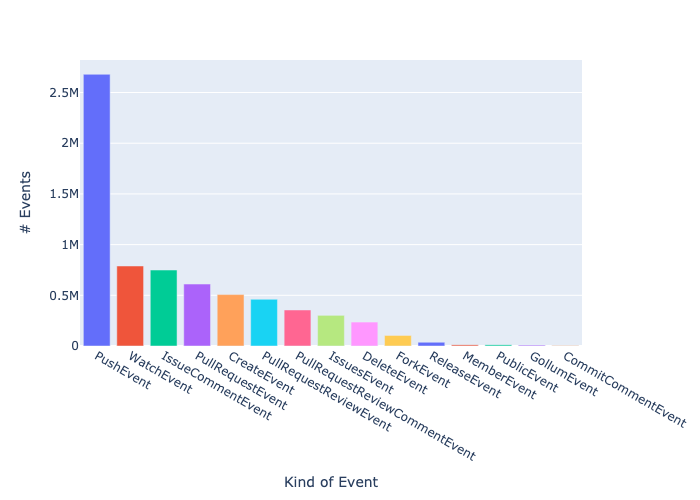

In [76]:
Image("general_eventcount.png")

### Repositories with the most events 

In [77]:
repo_event_counts = df_event_stream.repo_git.value_counts()
repo_event_counts

repo_git
https://api.github.com/repos/pytorch/pytorch                          64253
https://api.github.com/repos/llvm/llvm-project                        18243
https://api.github.com/repos/huggingface/transformers                 16758
https://api.github.com/repos/vllm-project/vllm                        14075
https://api.github.com/repos/langchain-ai/langchain                   13835
                                                                      ...  
https://api.github.com/repos/xinntao/ProjectTemplate-Python               1
https://api.github.com/repos/Abonaventure/ORB_SLAM3_AR-for-Android        1
https://api.github.com/repos/zhaoxuhui/ORB-Code-Notes                     1
https://api.github.com/repos/nik-suri/keplr-chain-registry                1
https://api.github.com/repos/StarlangSoftware/TurkishWordNet-Py           1
Name: count, Length: 549262, dtype: int64

Let's generate a bar chart that visualizes the number of events associated with different repositories. This chart is particularly focused on repositories with more than 2,500 events, filtering out those with fewer events to highlight the most active repositories.

- Data: The data is first processed by renaming the column in the `repo_event_counts` DataFrame to count. Then, it filters the repositories to include only those with more than 2,500 events.
- Color Encoding: Each bar is colored based on the repository name, providing a visual distinction between different repositories.

In [78]:
import plotly.express as px

# Convert repo_event_counts to a DataFrame and rename the column
df_fig_rec = repo_event_counts.to_frame().rename(columns={"repo_git": "count"})

# Filter the DataFrame to include only rows where count is greater than 2500
df_fig_rec = df_fig_rec[df_fig_rec["count"] > 2500]
df_fig_rec = df_fig_rec.reset_index()
# Extract the repository name from the 'repo_git' index (assuming the index contains URLs)
df_fig_rec['repo_name'] = df_fig_rec['repo_git'].str.extract(r'github\.com/repos/(.+)')

# Create the bar plot using the extracted repository names
fig_rec = px.bar(
    data_frame=df_fig_rec,
    x='repo_name',  # Use the trimmed repository name for the x-axis
    y='count',      # Use the 'count' column for the y-axis
    color='repo_name',  # Color by the repository name
    labels={
        "count": "# Contributor Events",
        "repo_name": "Repository"
    },
)

# Update the layout to increase the size of the graph
fig_rec.update_layout(
    showlegend=False,
    xaxis_tickangle=80,  # Optional: Rotate labels for better readability
    width=1400,           # Increase the width of the graph
    height=1000            # Increase the height of the graph
)

# Save and display the graph
fig_rec.write_image("general_repository_eventcount.png")
fig_rec


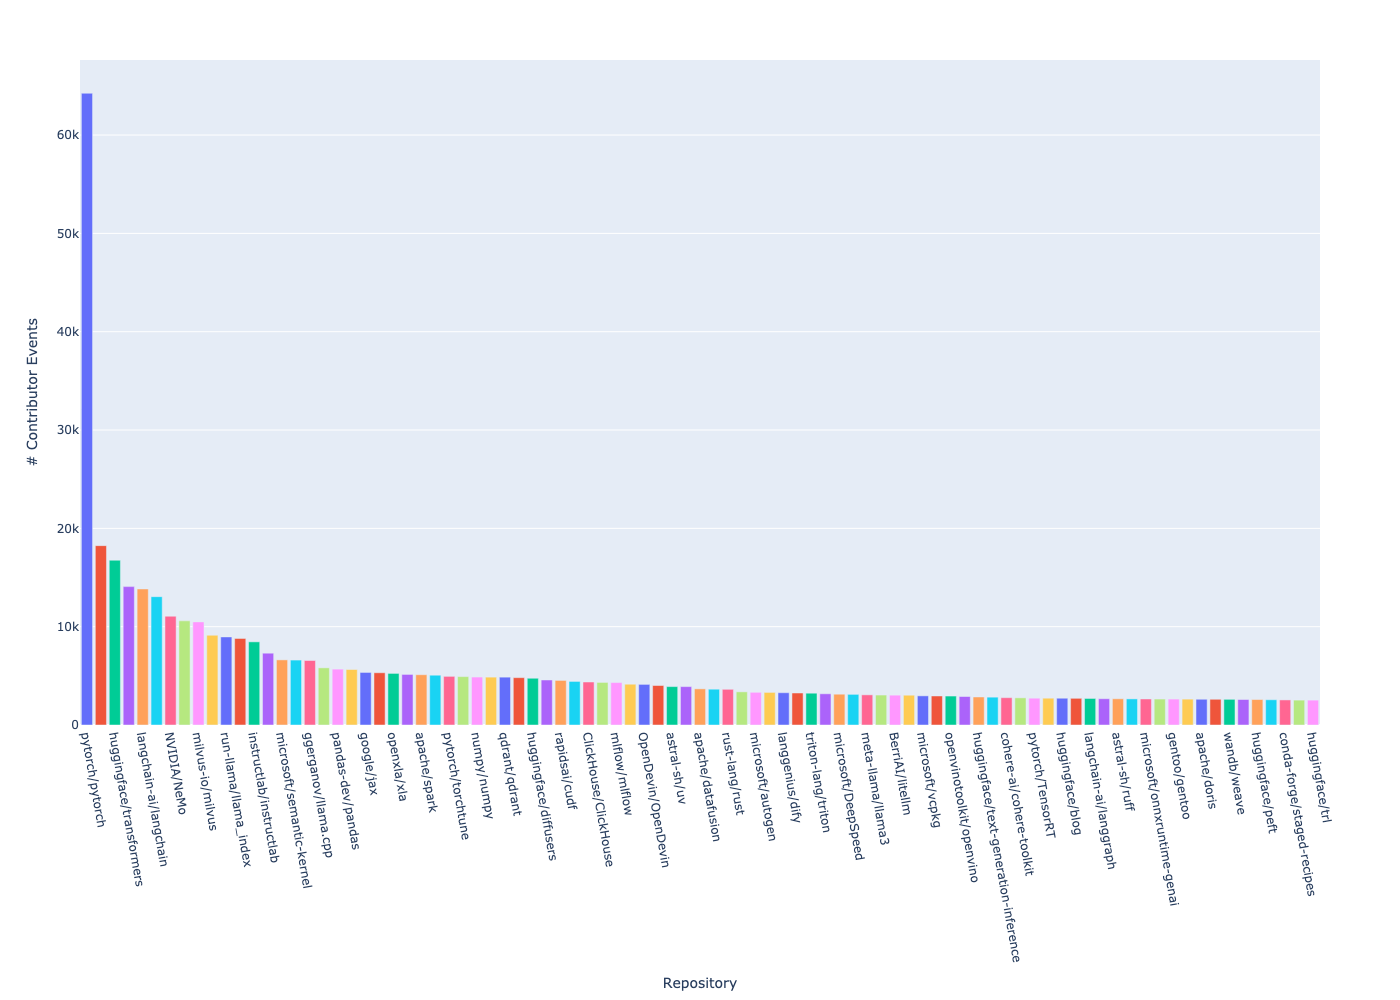

In [79]:
Image("general_repository_eventcount.png")

## Known Contributors Event Stream Analysis

We'd like to know which projects our group of contributors are the most active in. 

We'll cross-reference our event stream with the list of contributor IDs we have from our previous analysis.

In [80]:
UUID_known = df_known_contribs.cntrb_id.to_list()
UUID_known[:10]

['010000b4-3700-0000-0000-000000000000',
 '01012f1b-7f00-0000-0000-000000000000',
 '010000f2-1900-0000-0000-000000000000',
 '01000117-3e00-0000-0000-000000000000',
 '0100012d-d800-0000-0000-000000000000',
 '01000180-1a00-0000-0000-000000000000',
 '01000184-7400-0000-0000-000000000000',
 '010004e7-b700-0000-0000-000000000000',
 '0100051e-cf00-0000-0000-000000000000',
 '0100070f-d200-0000-0000-000000000000']

In [81]:
# only consider events from known contributors.
df_known_event_stream = df_event_stream[df_event_stream.cntrb_id.isin(UUID_known)]

### Difference in size:

The initial set of events represented the activity of the population of all Github users. 

By filtering by `UUID_known`, we now consider only those events from those contributors that we identified in our previous step; those that were in the initial set of repos that we believe are in our ecosystem of interest.

This change is from `6.8` Million events to `585K` events, nearly an order of magnitude difference.

In [82]:
print(f"Diff in size: {df_event_stream.shape} compared to {df_known_event_stream.shape}")

Diff in size: (6868909, 8) compared to (585507, 8)


### Most common events among known contributors

### General Event Count Bar Chart
Let's generate a bar chart that visualizes the frequency of different event types using Plotly Express. The chart is created from a DataFrame, `df_known_event_stream` containing event counts, with the event types represented on the x-axis and the number of occurrences on the y-axis.

- Data Source: The data used in this bar chart is derived from the `df_known_event_stream` DataFrame.
- Color Encoding: Each bar is colored based on the event type, allowing for easy differentiation between different types of events.
- Labels: The y-axis is labeled as # Events, representing the count of each event type, and the x-axis is labeled as Kind of Event to specify the types of events being counted.

In [83]:
kc_event_counts = df_known_event_stream.event_type.value_counts()
fig_kec = px.bar(
    data_frame=kc_event_counts.to_frame(),
    color=kc_event_counts.to_frame().index,
    labels={
                     "value": "# Events",
                     "event_type": "Kind of Event"
                 },
)
fig_kec.update_layout(showlegend=False)
fig_kec.write_image("knowncontributors_eventcount.png")
fig_kec

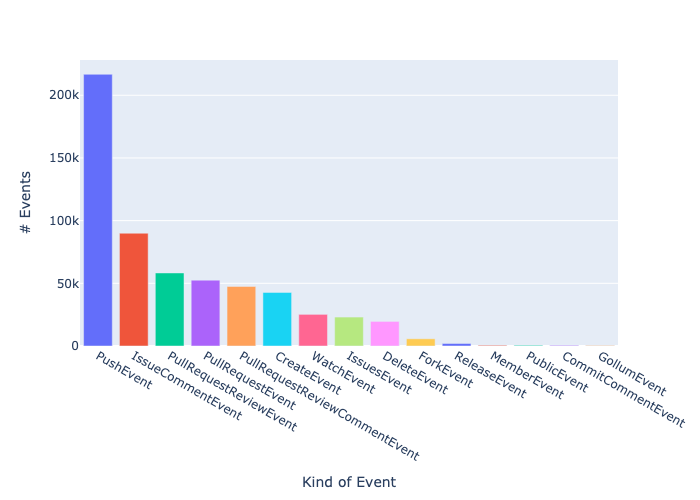

In [84]:
Image("knowncontributors_eventcount.png")

### Most common repositories among known contributors

Let's create a bar chart that visualizes the number of events contributed by known contributors to various repositories. The chart displays the top 50 repositories based on the number of contributor events. We are considering top 50 repositories based on the number of events as they have good number of events.

- Data Source: The data is sourced from the `kc_repo_event_counts` DataFrame, which counts the number of events associated with each repository URL contributed by known contributors.
- Color Encoding: Each bar is colored according to the repository URL, making it easy to distinguish between different repositories.
- Labels: The y-axis is labeled as `# Contributor Events`, representing the count of events per repository, and the x-axis is labeled as `Repository URL` to identify the repositories.

In [85]:
import json

# Load the seed list from ai_repos.json
with open('../ai_repos.json') as f:
    seed_list = json.load(f)

# Flatten the seed URLs into a single list
seed_repos = []
for category, repos in seed_list.items():
    seed_repos.extend(repos)

# Extract repository names from seed URLs
seed_repo_names = [url.split('github.com/')[1] for url in seed_repos]

kc_repo_event_counts = df_known_event_stream.repo_git.value_counts()
df_fig_rec_kc = kc_repo_event_counts.to_frame() 

# Reset the index to make 'repo_git' a column in the DataFrame
df_fig_rec_kc = df_fig_rec_kc.reset_index()

# Extract the repository name from the 'repo_git' URL (e.g., 'pytorch/pytorch')
df_fig_rec_kc['repo_name'] = df_fig_rec_kc['repo_git'].str.extract(r'github\.com/repos/(.+)')

# Add a column to indicate whether the repo is in the seed list
df_fig_rec_kc['is_seed_repo'] = df_fig_rec_kc['repo_git'].apply(
    lambda x: any(seed_repo in x for seed_repo in seed_repo_names)
)

In [86]:
import plotly.express as px

# Replace boolean values with 'Seed Repo' and 'Non Seed Repo' for legend
df_fig_rec_kc['is_seed_repo'] = df_fig_rec_kc['is_seed_repo'].replace({True: 'Seed Repo', False: 'Non Seed Repo'})

# Create the bar plot with a different color for seed repositories
fig_rec_kc = px.bar(
    data_frame=df_fig_rec_kc[:50],
    x='repo_name',
    y='count',
    color='is_seed_repo',  # Color by whether it's a seed repo
    labels={
        "count": "# Contributor Events",
        "repo_name": "Repository",
        "is_seed_repo": "Repository Type"
    },
    color_discrete_map={'Seed Repo': "blue", 'Non Seed Repo': "red"}  # Blue for seed repos, red for non-seed repos
)

# Update layout for better visualization
fig_rec_kc.update_layout(
    xaxis_tickangle=80,
    width=1400,
    height=1000
)

# Save and display the updated graph
fig_rec_kc.write_image("knowncontributors_repository_eventcount.png")
fig_rec_kc


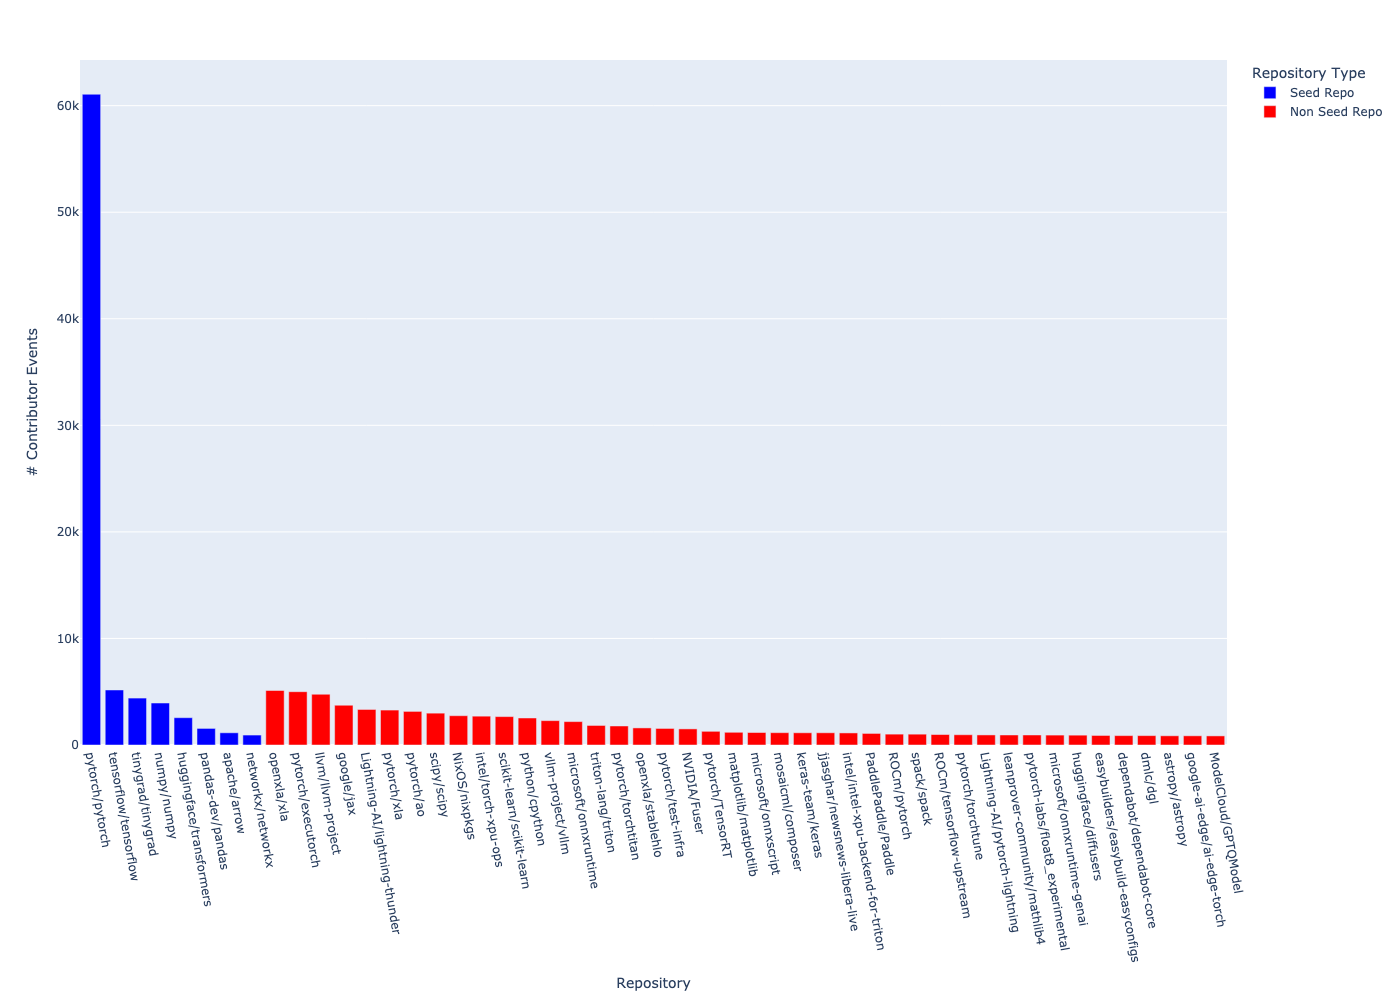

In [87]:
Image("knowncontributors_repository_eventcount.png")

## Interpretation

Our seed repositories are colored in blue and new reppositories that are found are colord in red. 
We find here that some obvious AI/ML repositories are contributed to most frequently by the contributors we already knew about.
Our challenge now is to find those repos that are *especially* popular among this population as compared to the popularity among the general public.

## Identify disproportionately popular repositories

## Unknown contributors

We want to consider the popularity of repos among people who aren't in our initial set.

If our 'known' group of contributors is the subpopulation "p" and the general population is "P", then the group of people who are in the general population but aren't in our sub-population is "P - p" or $\hat{P}$, pronounced P-hat.



Hence, $\hat{P}$ would be our unknown contributors.

In [88]:
# Get events made by those in P^

df_general_event_stream = df_event_stream[~df_event_stream.cntrb_id.isin(UUID_known)]
df_general_event_stream.shape

(6283402, 8)

In [89]:
# Count the events-per-repo of P^

g_repo_event_counts = df_general_event_stream.repo_git.value_counts().to_frame()
g_repo_event_counts

,count
repo_git,
https://api.github.com/repos/huggingface/transformers,14196
https://api.github.com/repos/langchain-ai/langchain,13761
https://api.github.com/repos/llvm/llvm-project,13480
https://api.github.com/repos/vllm-project/vllm,11789
https://api.github.com/repos/NVIDIA/NeMo,10568
...,...
https://api.github.com/repos/ConnectAI-E/Feishu-Stablediffusion,1
https://api.github.com/repos/haitusense/boilerplate,1
https://api.github.com/repos/DeSinc/SallyBot,1


Let's combine two sets of counts — one for a general population and another for a specific sub-population—into $\hat{P}$ a single DataFrame. Perform left join, ensuring that all data from the general population is preserved, and rename columns for clarity, and fill any missing data with zeros. The result is a DataFrame where each row represents an entity (like a repository) with its counts from both the general population and the sub-population.

In [90]:
# Join the counts of P^ with those of p

joined_counts = g_repo_event_counts.join(
    other=kc_repo_event_counts.to_frame(),
    how="left",
    lsuffix="_general",
    rsuffix="_known",
)

joined_counts = joined_counts.rename(columns={"repo_git_general": "count_general", "repo_git_known": "count_known"})
joined_counts = joined_counts.fillna(0)
joined_counts

,count_general,count_known
repo_git,,
https://api.github.com/repos/huggingface/transformers,14196,2562.0
https://api.github.com/repos/langchain-ai/langchain,13761,74.0
https://api.github.com/repos/llvm/llvm-project,13480,4763.0
https://api.github.com/repos/vllm-project/vllm,11789,2286.0
https://api.github.com/repos/NVIDIA/NeMo,10568,495.0
...,...,...
https://api.github.com/repos/ConnectAI-E/Feishu-Stablediffusion,1,0.0
https://api.github.com/repos/haitusense/boilerplate,1,0.0
https://api.github.com/repos/DeSinc/SallyBot,1,0.0


## Simple approach

In this figure we visualize the count of contributions from those in 'p' and $\hat{P}$ stacked on top of one another. 

Most of the most-contributed-to projects of those in 'p' are also most-contributed-to by members of 'p' (they are not also largely contributed to by those in $\hat{P}$).

Some notable visual exceptions are `huggingface/transformers`, `langchain-ai/langchain`, `llvm/llvm-project`, and `NVIDIA/NeMo`.

In [91]:
import plotly.express as px

# Sort the DataFrame by 'count_known' and take the first 50 rows
top_joined_counts = joined_counts.sort_values(by="count_known", ascending=False).head(50)
# Reset the index to make 'repo_git' a column in the DataFrame
top_joined_counts = top_joined_counts.reset_index()
# Extract the repository name from the 'repo_git' URL (e.g., 'pytorch/pytorch')
top_joined_counts['repo_name'] = top_joined_counts['repo_git'].str.extract(r'github\.com/repos/(.+)')

# Create the bar plot
fig_joined_counts = px.bar(
    data_frame=top_joined_counts,
    x="repo_name",  # Use the trimmed repository name for the x-axis
    y=["count_general", "count_known"],  # Use the counts for the y-axis
    labels={
        "value": "# Contributor Events",
        "repo_name": "Repository"
    },
    color_discrete_map={
        "count_general": "blue",  # Blue for general population (complementary, \hat{P})
        "count_known": "red"      # Red for known population (p)
    }
)

# Update the layout to include the legend and increase the size of the graph
fig_joined_counts.update_layout(
    showlegend=True,   # Show the legend to explain the colors
    xaxis_tickangle=80,  # Optional: Rotate labels for better readability
    width=1200,           # Increase the width of the graph
    height=800            # Increase the height of the graph
)

# Save and display the graph
fig_joined_counts.write_image("joined_counts.png")
fig_joined_counts


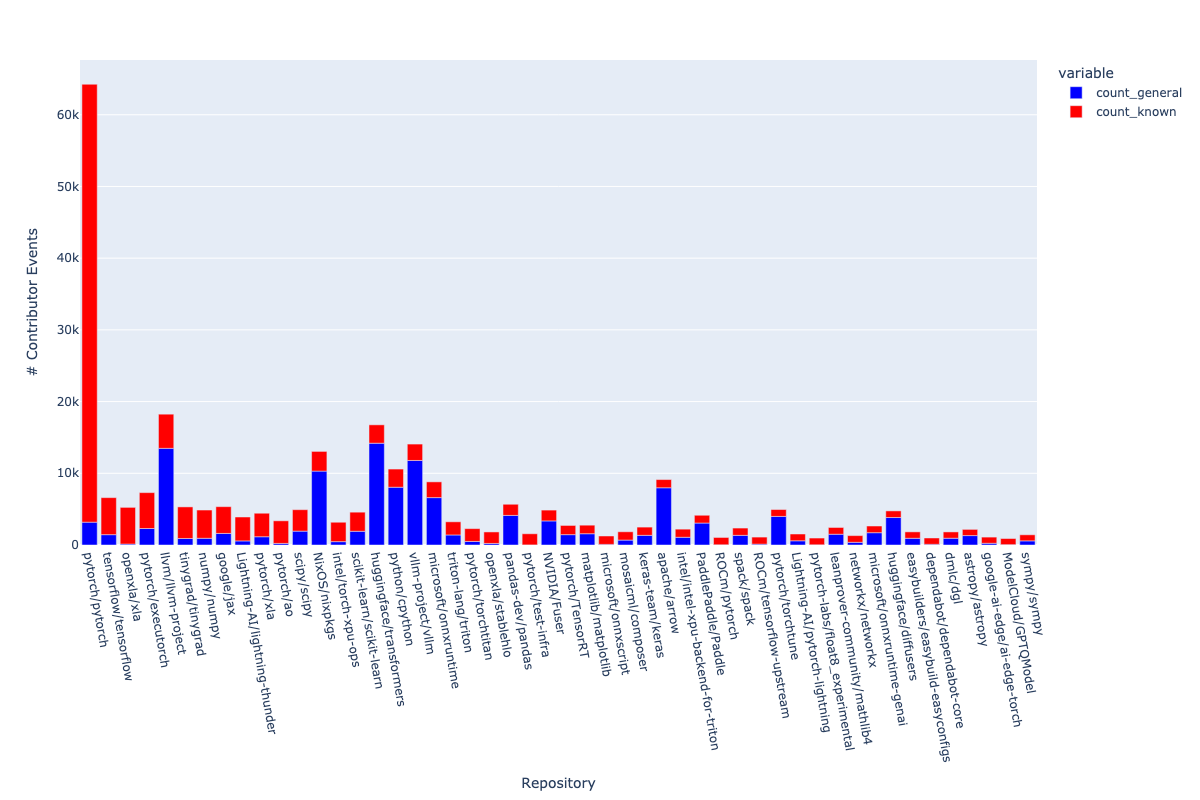

In [92]:
Image('joined_counts.png')

### Interpretation

Above, the Red parts of the bars represent the count of events from our known population 'p', whereas the Blue parts of the stacks represent the complementary population $\hat{P}$.

From left to right, descending, are the projects with the largest number of contribution events (number of contribution events) from people in 'p'.

The people from our subpopulation should 100% dominate projects like pytorch, because those are among the populations whose population we're directly considering.

This opens an interesting new line of inquiry. If the overlap of contributors between projects was extremely ecosystem-specific, e.g. people from AI/ML MOSTLY participated in AI/ML related projects(blue parts), then we could easily start with any AI/ML project and find those projects with greatest contributor overlap, and identify that those are all the AI/ML projects. 


### Conclusion

There isn't free lunch here. We need to use more sensitive methods to 'sniff out' AI/ML related repositories, considering not only WHO is contributing WHERE, but who their social network is and what their behavior is within the 'seed' communities we start with.


## Implement alpha and beta indices of preference

Mathematical definition of following approach:

https://www.overleaf.com/read/hxnsqsydqcrw#f624f4

### Implement alpha

'alpha' is a probablistic contribution metric. It captures 'how much more or less likely' the subpopulation 'p' is to contribute to a repository relative to the general population $\hat{P}$.

More details can be found in the overleaf document referenced at the top of this section.

In [93]:
# probabilities of contribution in known population

# number of contribution events by our contributor subpopulation
n_known = joined_counts["count_known"].sum()

# divide the per-repo contribution count by the total num of contributions by population.
# this is interpretateable as "the probability that the subpopulation will contribute to a given repo"
joined_counts["p_known"] = joined_counts["count_known"] / n_known
joined_counts

,count_general,count_known,p_known
repo_git,,,
https://api.github.com/repos/huggingface/transformers,14196,2562.0,0.006686
https://api.github.com/repos/langchain-ai/langchain,13761,74.0,0.000193
https://api.github.com/repos/llvm/llvm-project,13480,4763.0,0.012429
https://api.github.com/repos/vllm-project/vllm,11789,2286.0,0.005965
https://api.github.com/repos/NVIDIA/NeMo,10568,495.0,0.001292
...,...,...,...
https://api.github.com/repos/ConnectAI-E/Feishu-Stablediffusion,1,0.0,0.000000
https://api.github.com/repos/haitusense/boilerplate,1,0.0,0.000000
https://api.github.com/repos/DeSinc/SallyBot,1,0.0,0.000000


In [94]:
# Probabilities of contribution in general population:

# number of contribution events by the general population.
n_general = joined_counts["count_general"].sum()

# divide the per-repo contribution count by the total num of contributions by general population.
# this is interpretateable as "the probability that the general population will contribute to a given repo"
joined_counts["p_everyone"] = (joined_counts["count_general"] + joined_counts["count_known"]) / (n_general + n_known)
joined_counts

,count_general,count_known,p_known,p_everyone
repo_git,,,,
https://api.github.com/repos/huggingface/transformers,14196,2562.0,0.006686,2.513722e-03
https://api.github.com/repos/langchain-ai/langchain,13761,74.0,0.000193,2.075268e-03
https://api.github.com/repos/llvm/llvm-project,13480,4763.0,0.012429,2.736474e-03
https://api.github.com/repos/vllm-project/vllm,11789,2286.0,0.005965,2.111269e-03
https://api.github.com/repos/NVIDIA/NeMo,10568,495.0,0.001292,1.659465e-03
...,...,...,...,...
https://api.github.com/repos/ConnectAI-E/Feishu-Stablediffusion,1,0.0,0.000000,1.500013e-07
https://api.github.com/repos/haitusense/boilerplate,1,0.0,0.000000,1.500013e-07
https://api.github.com/repos/DeSinc/SallyBot,1,0.0,0.000000,1.500013e-07


In [95]:
# calculate alpha

# by what factor is the subpopulation more or less likely to contribute to a repo?
joined_counts["alpha"] = joined_counts["p_known"] / joined_counts["p_everyone"]
joined_counts

,count_general,count_known,p_known,p_everyone,alpha
repo_git,,,,,
https://api.github.com/repos/huggingface/transformers,14196,2562.0,0.006686,2.513722e-03,2.659681
https://api.github.com/repos/langchain-ai/langchain,13761,74.0,0.000193,2.075268e-03,0.093052
https://api.github.com/repos/llvm/llvm-project,13480,4763.0,0.012429,2.736474e-03,4.542103
https://api.github.com/repos/vllm-project/vllm,11789,2286.0,0.005965,2.111269e-03,2.825533
https://api.github.com/repos/NVIDIA/NeMo,10568,495.0,0.001292,1.659465e-03,0.778404
...,...,...,...,...,...
https://api.github.com/repos/ConnectAI-E/Feishu-Stablediffusion,1,0.0,0.000000,1.500013e-07,0.000000
https://api.github.com/repos/haitusense/boilerplate,1,0.0,0.000000,1.500013e-07,0.000000
https://api.github.com/repos/DeSinc/SallyBot,1,0.0,0.000000,1.500013e-07,0.000000


In [96]:
joined_counts.sort_values(by=["alpha"], ascending=False)[:10]

,count_general,count_known,p_known,p_everyone,alpha
repo_git,,,,,
https://api.github.com/repos/hyperledger/cacti,1,477.0,0.001245,0.000072,17.360535
https://api.github.com/repos/duburcqa/jiminy,1,390.0,0.001018,0.000059,17.352437
https://api.github.com/repos/PTB-MR/mrpro,1,381.0,0.000994,0.000057,17.351388
https://api.github.com/repos/cisco-open/pymultiworld,1,368.0,0.000960,0.000055,17.349784
https://api.github.com/repos/lab-cosmo/metatrain,1,339.0,0.000885,0.000051,17.345763
https://api.github.com/repos/xapi-project/xen-api,1,279.0,0.000728,0.000042,17.334798
https://api.github.com/repos/hugovk/drop-python,1,278.0,0.000725,0.000042,17.334576
https://api.github.com/repos/cosdt/dockerfiles,1,238.0,0.000621,0.000036,17.324140
https://api.github.com/repos/zucchini-nlp/transformers,1,214.0,0.000558,0.000032,17.316014


Those repos that our subcommunity dominates (those that they own) are ~17x more likely to be contributed to (naturally) than by the general population.

e.g. for 'hyperledger/cacti', |p|=477 and |$\hat{P}$|=1, so the probability that the subpopulation contributes to this particular project is measured as significantly higher than the general population.

However, 477 events still isn't many relative to the number of events we observe for large projects (2562 for huggingface/transformers), so this isn't a terribly strong indication that the project is 'important' to the AI/ML ecosystem in general.

In [97]:
top_alpha_scores = joined_counts.sort_values(by="alpha", ascending=False).head(100)
top_alpha_scores = top_alpha_scores.reset_index()
# Extract the repository name from the 'repo_git' URL (assuming there's a 'repo_git' column)
top_alpha_scores['repo_name'] = top_alpha_scores['repo_git'].str.extract(r'github\.com/repos/(.+)')

# Create the bar plot using the extracted repository names
fig = px.bar(
    data_frame=top_alpha_scores,
    x='repo_name',  # Use the trimmed repository name for the x-axis
    y="alpha",  # Use 'alpha' for the y-axis
    hover_data=["alpha", "count_known", "count_general"],  # Add hover data
    labels={
        "alpha": "Alpha Score",
        "repo_name": "Repository"  # Label for the x-axis
    },
)

# Update the layout to increase the size of the graph
fig.update_layout(
    width=1400,  # Increase the width of the graph
    height=500,  # Increase the height of the graph
    xaxis_tickangle=80,  # Rotate labels for better readability
)

# Save and display the graph
fig.write_image("alpha_scores.png")
fig

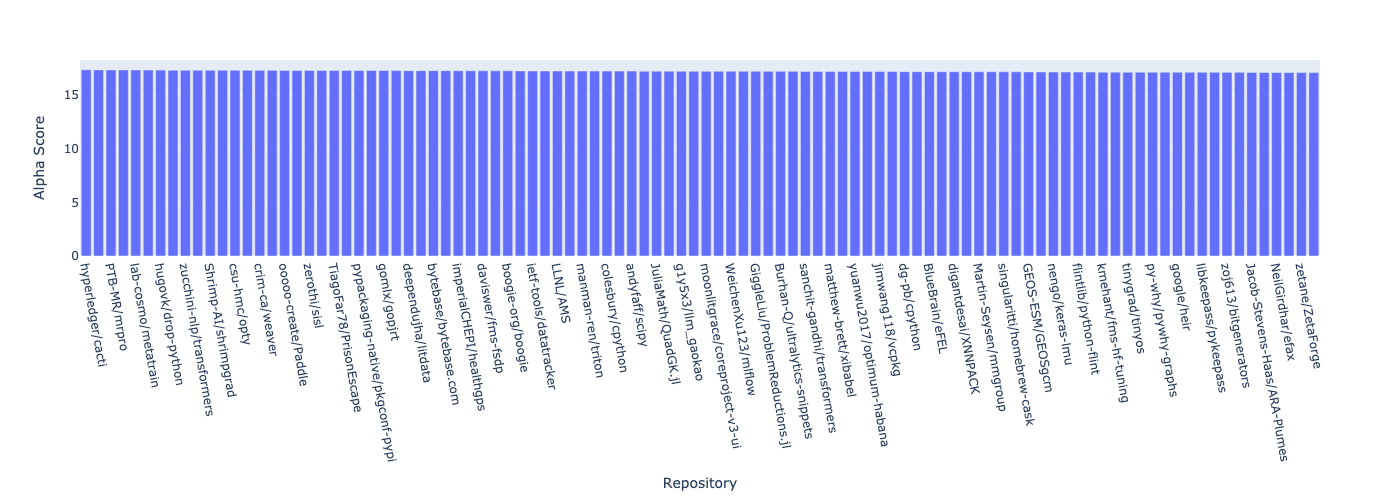

In [98]:
Image("alpha_scores.png")

To understand this graph, let's take a given alpha value and interpret it.

For `hyperledger/cacti`, the alpha value is 17.3 - we can interpret this value as "Members of the subpopulation 'p' are 17x more likely to contribute to this repository than members of the general population $\hat{P}$ are."

Most of the alpha values we see in this top-100 alpha values plot are similar enough that the graph looks flat, but they're all slightly different values, based on count_general and count_known.

Observing the top 1000 repos by alpha value, the alpha value decreases fairly steadily without major outliers.

### Takeaway

Top repos by Alpha are:
- hyperledger/cacti
- duburcqa/jiminy
- PTB-MR/mrpro
- cisco-open/pymultiworld
- lab-cosmo/metatrain
- xapi-project/xen-api
- hugovk/drop-python
- cosdt/dockerfiles
- zucchini-nlp/transformers
- maruel/sillybot

### Implement beta

'beta' attempts to connect the probablistic metric that 'alpha' provides to the real volume of contribution events that a repo experiences. The number of events is log-scaled so that orders-of-magnitude differences are smoothed out.

Ideally, 'beta' allows us to see which repos are not only disproportionately 'popular' among the subpopulation (which can be biased toward projects that are ONLY contributed to by our subpopulation) but are also GENERALLY seeing lots of work being done.

In [99]:
# take the log of the count of known contributors.
# This reduces the impact of very high contribution volume, shifting the 
# impact toward the alpha value.

joined_counts["log_count_known"] = joined_counts["count_known"].apply(lambda x: math.log(x) if x>0 else 0)

In [100]:
joined_counts["beta"] = joined_counts["alpha"] * joined_counts["log_count_known"] 
joined_counts[:10]

,count_general,count_known,p_known,p_everyone,alpha,log_count_known,beta
repo_git,,,,,,,
https://api.github.com/repos/huggingface/transformers,14196,2562.0,0.006686,0.002514,2.659681,7.848543,20.874622
https://api.github.com/repos/langchain-ai/langchain,13761,74.0,0.000193,0.002075,0.093052,4.304065,0.400501
https://api.github.com/repos/llvm/llvm-project,13480,4763.0,0.012429,0.002736,4.542103,8.468633,38.465400
https://api.github.com/repos/vllm-project/vllm,11789,2286.0,0.005965,0.002111,2.825533,7.734559,21.854254
https://api.github.com/repos/NVIDIA/NeMo,10568,495.0,0.001292,0.001659,0.778404,6.204558,4.829651
https://api.github.com/repos/milvus-io/milvus,10480,7.0,0.000018,0.001573,0.011612,1.945910,0.022597
https://api.github.com/repos/NixOS/nixpkgs,10303,2749.0,0.007174,0.001958,3.664125,7.918992,29.016179
https://api.github.com/repos/run-llama/llama_index,8290,669.0,0.001746,0.001344,1.299090,6.505784,8.451598
https://api.github.com/repos/python/cpython,8056,2535.0,0.006615,0.001589,4.164028,7.837949,32.637437


In [101]:
joined_counts.sort_values(by="beta", ascending=False)[:10]

,count_general,count_known,p_known,p_everyone,alpha,log_count_known,beta
repo_git,,,,,,,
https://api.github.com/repos/pytorch/pytorch,3182,61071.0,0.159369,0.009638,16.535382,11.019792,182.216480
https://api.github.com/repos/openxla/xla,132,5115.0,0.013348,0.000787,16.959271,8.539933,144.831037
https://api.github.com/repos/pytorch/ao,221,3153.0,0.008228,0.000506,16.257416,8.056110,130.971524
https://api.github.com/repos/pytorch/test-infra,13,1553.0,0.004053,0.000235,17.252511,7.347944,126.770483
https://api.github.com/repos/tinygrad/tinygrad,909,4404.0,0.011493,0.000797,14.420493,8.390268,120.991810
https://api.github.com/repos/Lightning-AI/lightning-thunder,570,3335.0,0.008703,0.000586,14.857557,8.112228,120.527893
https://api.github.com/repos/intel/torch-xpu-ops,467,2707.0,0.007064,0.000476,14.837268,7.903596,117.267779
https://api.github.com/repos/ROCm/pytorch,31,1020.0,0.002662,0.000158,16.883795,6.927558,116.963469
https://api.github.com/repos/numpy/numpy,937,3940.0,0.010282,0.000732,14.054522,8.278936,116.356490


In [102]:
top_beta_scores = joined_counts.sort_values(by="beta", ascending=False).head(100)
top_beta_scores

,count_general,count_known,p_known,p_everyone,alpha,log_count_known,beta
repo_git,,,,,,,
https://api.github.com/repos/pytorch/pytorch,3182,61071.0,0.159369,0.009638,16.535382,11.019792,182.216480
https://api.github.com/repos/openxla/xla,132,5115.0,0.013348,0.000787,16.959271,8.539933,144.831037
https://api.github.com/repos/pytorch/ao,221,3153.0,0.008228,0.000506,16.257416,8.056110,130.971524
https://api.github.com/repos/pytorch/test-infra,13,1553.0,0.004053,0.000235,17.252511,7.347944,126.770483
https://api.github.com/repos/tinygrad/tinygrad,909,4404.0,0.011493,0.000797,14.420493,8.390268,120.991810
...,...,...,...,...,...,...,...
https://api.github.com/repos/TiagoFar78/PrisonEscape,1,173.0,0.000451,0.000026,17.296948,5.153292,89.136215
https://api.github.com/repos/huggingface/optimum-quanto,74,415.0,0.001083,0.000073,14.764266,6.028279,89.003107
https://api.github.com/repos/nerfstudio-project/viser,18,243.0,0.000634,0.000039,16.197142,5.493061,88.971895


In [103]:
top_beta_scores = joined_counts.sort_values(by="beta", ascending=False).head(100)
top_beta_scores = top_beta_scores.reset_index()
# Extract the repository name from the 'repo_git' URL (assuming there's a 'repo_git' column)
top_beta_scores['repo_name'] = top_beta_scores['repo_git'].str.extract(r'github\.com/repos/(.+)')

# Create the bar plot using the extracted repository names
fig = px.bar(
    data_frame=top_beta_scores,
    x='repo_name',  # Use the trimmed repository name for the x-axis
    y="beta",  # Use 'beta' for the y-axis
    hover_data=["alpha", "log_count_known", "count_known", "count_general"],  # Add hover data
    labels={
        "beta": "Beta Score",
        "repo_name": "Repository"  # Label for the x-axis
    },
)

# Update the layout to increase the size of the graph
fig.update_layout(
    width=1400,  # Increase the width of the graph
    height=1000,  # Increase the height of the graph
    xaxis_tickangle=80,  # Rotate labels for better readability
)

# Save and display the graph
fig.write_image("beta_scores.png")
fig

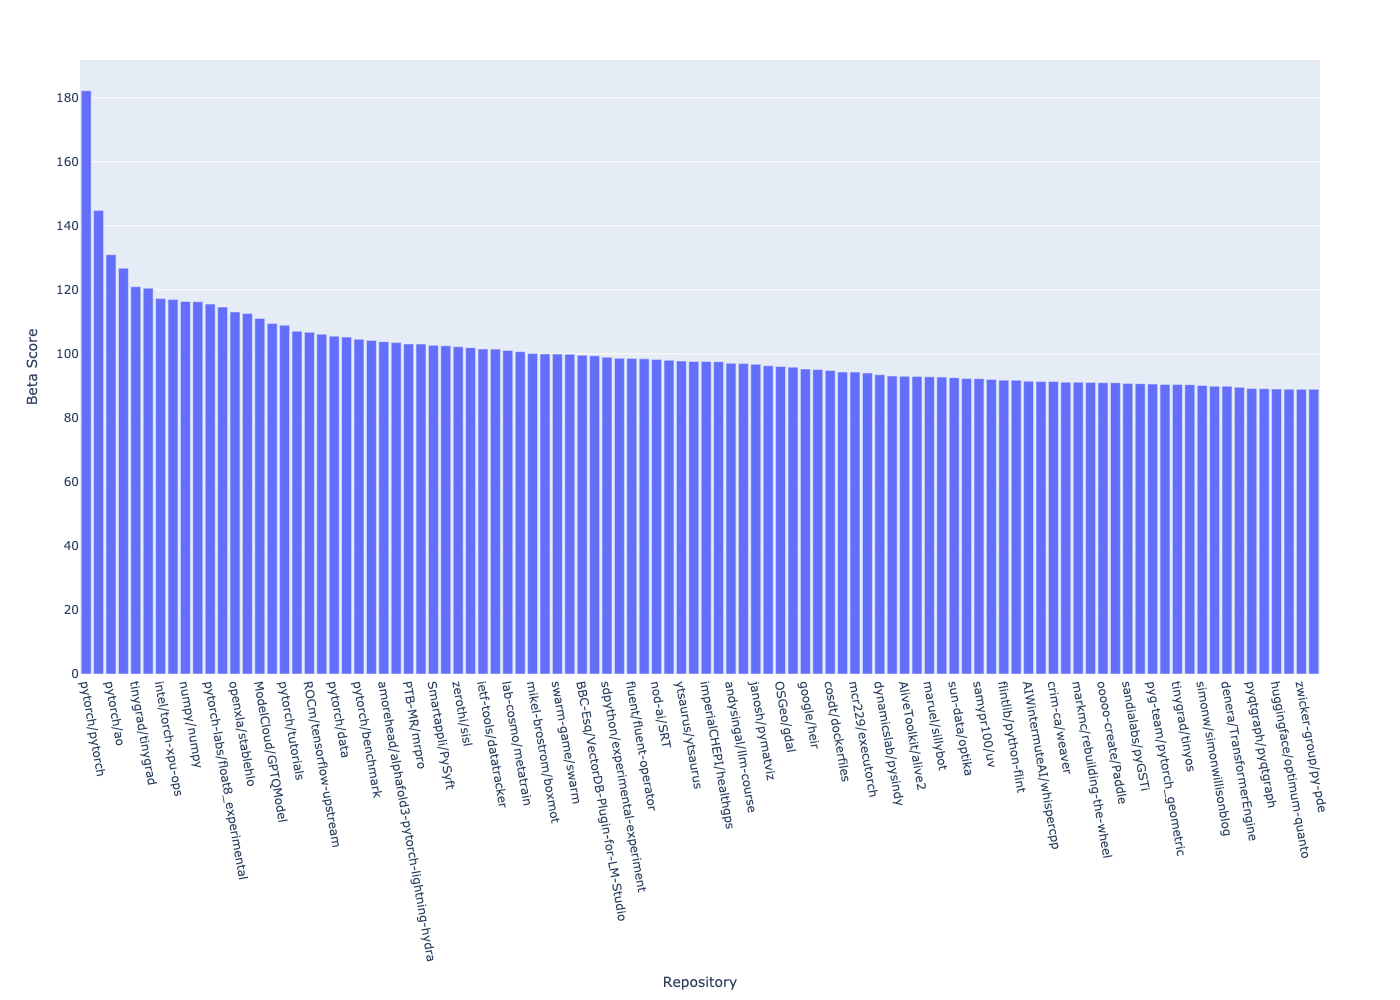

In [104]:
Image("beta_scores.png")

'beta' as a raw number is fairly arbitrary, but as a relative value, it lends to an informative comparison between projects.

'Higher' beta values "score better" w.r.t popularity and contribution volume from contributors, while 'lower' values are likely lower in contribution volume or in proportional popularity than their peer projects.
The balance between the impact of these two considerations deserves significant refinement, and is an opportunity for further work.

### Takeaway

Top repos by 'beta' value are:

- pytorch/pytorch	
- openxla/xla	
- pytorch/ao	
- pytorch/test-infra	
- tinygrad/tinygrad	
- Lightning-AI/lightning-thunder	
- intel/torch-xpu-ops	
- ROCm/pytorch	
- numpy/numpy	
- tensorflow/tensorflow

pytorch, tinygrad, numpy, and tensorflow are our seed repositories, while others are new repositories.

## Conclusion

The alpha and beta metrics proposed in this work attempt to inspect the distinction between projects that are 'popular' within a subgroup working on an ecosystem of interest
and those that are 'massively contributed to.' A project might be very popular numerically within a subpopulation because they're the exclusive contributors to that project,
but the amount of work being done might be comparatively low. Likewise, a project could be astonomically interesting to the general population, and thereby interesting to many people within our subpopulation, but be RELATIVELY less interesting compared to other projects that our subpopulation is working on.

This notebook applies alpha and beta to the behavior of our subgroup and identifies projects that are both popular and largely contributed to by our subpopulation of interest.

Notably, we can see that the "most popular" general project, `huggingface/transformers`, is not present in the 'top repos by beta value'.

## '**The Core Problem**' or Limitation

I would like to thank James for reviewing and bringing this problem to our notice.
The core problem is that the Event Stream fetched from the Augur Database isn't representative of the population of GitHub (perhaps it really never was in the original work) so we can't draw conclusions about the results. The database that this work is using might be based on a set of repos that are assumed to be AI facing, rather than a roughly random set of repos.

The only solution that can be thought of now is to rebulid the database, which is out of scope of the current project.

## Further Work

These results are interesting but they further substantiate that count-based identification of repositories within an ecosystem is a weak signal at best.
Future work should look beyond simply "counting people" and "counting contribution events."